In [99]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import misc
from scipy import optimize
from tqdm import tqdm
import os 
import pandas as pd 
from misc import *
from scipy import optimize
from math import erf
from agent import Agent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Helstrom

In [81]:
def coherent_state(alpha,Ntrunc=30):
    return np.exp(-alpha**2/2)*np.array([np.power(alpha,n)/np.sqrt(float(np.math.factorial(n))) for n in range(Ntrunc)])

def rho(state):
    if len(list(state.shape))>1:
        pass
    else:
        state = np.expand_dims(state, [0])
    return np.dot(state.T,state)

def helstrom_bound(alpha, epsilon=0.01):
    rhoAP = rho(coherent_state(alpha))
    rhoAM = rho(coherent_state(-alpha))
    rhoBP = rho(coherent_state(np.sqrt(epsilon)*alpha))
    rhoBM = rho(coherent_state(-np.sqrt(epsilon)*alpha))
    
    return 0.5*(1+ 0.5*np.sum(np.abs(  np.linalg.eigvals((rhoAP + rhoBP)/2  - (rhoAM + rhoBM)/2 ))))

In [10]:
agent =Agent(channel={"class":"compound_lossy", "params":[0.5, 0.01]})

24

In [82]:
def homodyne(a=0.4, ep=0.01):
    beta = np.sqrt(ep)*a
    p_err =  (1- erf(np.sqrt(2)*a) + 1 - erf(np.sqrt(2)*beta))/4
    return 1-p_err

def success_probability_1L(betas, amplitude=0.4):
    b0= betas[0]
    p=0
    for n1 in [0,1]:
        ## best guess ?
        pguess = [0,0]
        for arg,ph in enumerate([-1,1]):
            for att in [0.01, 1]:
                pguess[arg]+=agent.P(np.sqrt(att)*ph*amplitude, b0 ,1, n1)/4
        ## best guess ?
        ph = [-1,1][np.argmax(pguess)]
        for att in [0.01, 1]:
            p+=agent.P(np.sqrt(att)*ph*amplitude, b0 ,1, n1)/4
    return -p

In [84]:
amplitudes = np.linspace(.4,4,25)
optvals1L = np.zeros(len(amplitudes))
for inda, a in enumerate(tqdm(amplitudes)):
    blim = 8*a
    f=optimize.dual_annealing(success_probability_1L,([(-blim,blim)])*1, args=[a], maxiter=1000,no_local_search=True )
    optvals1L[inda] = -f.fun
    optbetas1L[inda] = f.x

100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


In [92]:
agent =Agent(channel={"class":"compound_lossy", "params":[0.5, 0.01]})
def success_probability_2L(betas, amplitude=0.4):
    b0, b1 ,b2 = betas
    p=0
    for n1,n2 in zip([0,0,1,1],[0,1,0,1]):
        ## best guess ?
        pguess = [0,0]
        for arg,ph in enumerate([-1,1]):
            for att in [0.01, 1]:
                pguess[arg]+=agent.P(np.sqrt(att)*ph*amplitude, b0 ,1/np.sqrt(2), n1)*agent.P(np.sqrt(att)*ph*amplitude, [b1,b2][n1] ,1/np.sqrt(2), n2)/4
        ## best guess ?
        ph = [-1,1][np.argmax(pguess)]
        for att in [0.01, 1]:
            p+=agent.P(np.sqrt(att)*ph*amplitude, b0 ,1/np.sqrt(2), n1)*agent.P(np.sqrt(att)*ph*amplitude, [b1,b2][n1] ,1/np.sqrt(2), n2)/4
    return -p

In [94]:
optvals2L = np.zeros(len(amplitudes))
optbetas2L = np.zeros((len(amplitudes), 3))
for inda, a in enumerate(tqdm(amplitudes)):
    blim = 10*a
    f=optimize.dual_annealing(success_probability_2L,([(-blim,blim)])*3, args=[a], maxiter=2000,no_local_search=True )
    optvals2L[inda] = -f.fun
    optbetas2L[inda] = f.x

100%|██████████| 25/25 [02:10<00:00,  5.21s/it]


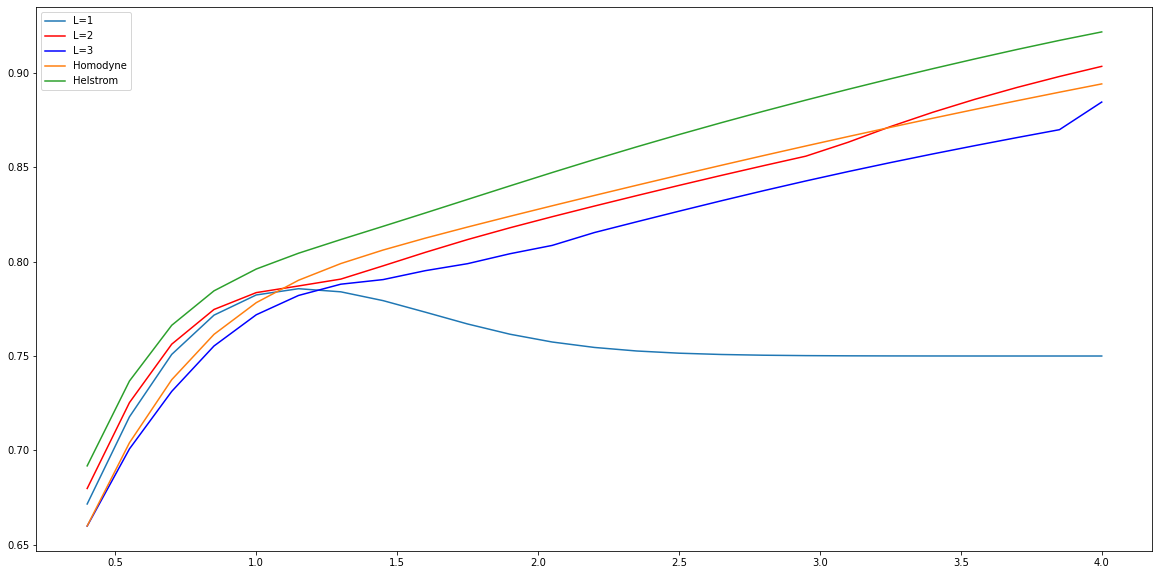

In [112]:
plt.figure(figsize=(20,10))

helstroms = np.array([helstrom_bound(a) for a in amplitudes])
homodynes = np.array([homodyne(a) for a in amplitudes])
plt.plot(amplitudes,optvals1L, label="L=1")
plt.plot(amplitudes,optvals2L, color="red",label="L=2")
plt.plot(amplitudes,optvals3L, color="blue",label="L=3")

plt.plot(amplitudes,homodynes, label="Homodyne")
plt.plot(amplitudes,helstroms,label="Helstrom")
plt.legend()

In [108]:
agent =Agent(channel={"class":"compound_lossy", "params":[0.5, 0.01]})
def success_probability_3L(betas, amplitude=0.4,L=3):
    b0, b1 ,b2,b3, b4, b5, b6 = betas
    p=0
    for n1,n2,n3 in zip(*misc.outcomes_universe(3).T):
        ## best guess ?
        pguess = [0,0]
        for arg,ph in enumerate([-1,1]):
            for att in [0.01, 1]:
                pguess[arg]+=agent.P(np.sqrt(att)*ph*amplitude, b0 ,1/np.sqrt(L), n1)*agent.P(np.sqrt(att)*ph*amplitude, [b1,b2][n1] ,1/np.sqrt(L), n2)*agent.PP(ph*np.sqrt(att)*amplitude, np.array([[b3,b4],[b5,b6]])[n1,n2] ,1/np.sqrt(L), n3) /4
        ## best guess ?
        ph = [-1,1][np.argmax(pguess)]
        for att in [0.01, 1]:
            p+=agent.P(np.sqrt(att)*ph*amplitude, b0 ,1/np.sqrt(L), n1)*agent.P(np.sqrt(att)*ph*amplitude, [b1,b2][n1] ,1/np.sqrt(L), n2)*agent.PP(np.sqrt(att)*ph*amplitude, np.array([[b3,b4],[b5,b6]])[n1,n2] ,1/np.sqrt(L), n3) /4
    return -p

/home/cooper-cooper/Desktop/marek/agent.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.q_table = np.array(self.q_table)
/home/cooper-cooper/Desktop/marek/agent.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.n_table = np.array(self.n_table)


In [109]:
amplitudes = np.linspace(.4, 4,25)
optvals3L = np.zeros(len(amplitudes))
optbetas3L = np.zeros((len(amplitudes), 7))
for inda, a in enumerate(tqdm(amplitudes)):
    blim = 4*a
    f=optimize.dual_annealing(success_probability_3L,([(-blim,blim)])*7, args=[a], maxiter=2000,no_local_search=True )
    optvals3L[inda] = -f.fun
    optbetas3L[inda] = f.x

100%|██████████| 25/25 [19:46<00:00, 47.45s/it]
